## This notebook does the whole-brain voxel-wise GLM fitting

We use FSL FEAT

In [4]:
import pandas as pd
import numpy as np
import glob

# for masking
from nilearn.input_data import NiftiMasker
import nibabel as nib
import itertools
import multiprocessing as mp

import os
import shutil

# 1. First, make event files

In [5]:
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')
events['onset'] -= 1.5  # slice time correction

In [6]:
def get_sub_n(sub, max_sub_ds1=19):
    if sub > max_sub_ds1:
        sub -= max_sub_ds1
        ds = 2
    else:
        ds = 1
    return ds, sub

#### Events of interest

In [4]:
include_events = ['easy', 'hard', 'error', 'response_left', 'response_right', 'cue_left', 'cue_neutral', 'cue_right']

for (subject, run), events_ in events.groupby(level=[0,1]):
    ds, sub = get_sub_n(subject)    
    output_dir = './derivatives/ds-{ds}/feat_files/sub-{sub}/run-{run}/evs/'.format(**{'ds':str(ds).zfill(2), 'sub':str(sub).zfill(2), 'run':run})
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    events_['weight'] = 1
    for i, ev in enumerate(include_events):
        events_.loc[events_['event_type']==ev, ['onset', 'duration', 'weight']].to_csv(output_dir+'{}.txt'.format(ev), sep='\t', index=False, header=False)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### Confounds

In [5]:
for (subject, run), confounds_ in confounds.groupby(level=[0,1]):
    ds, sub = get_sub_n(subject)
    output_dir = './derivatives/ds-{ds}/feat_files/sub-{sub}/run-{run}/evs/'.format(**{'ds':str(ds).zfill(2), 'sub':str(sub).zfill(2), 'run':run})
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    confounds_.to_csv(output_dir+'confounds.txt', sep='\t', index=False, header=False)

# 2. Mask functional data and fix header (set TR = 3)

For some reason, the fmriprep output (or perhaps already the sourcedata / input) has the TR set wrongly in the header of the nifti files. Here, we correct this using `fslmerge`. Furthermore, we apply a brain mask to the functional data.

In [7]:
def mask_img(img, mask):
    masker = NiftiMasker(mask)
    data_masked = masker.fit_transform(img)
    data_masked_epispace = masker.inverse_transform(data_masked)
    return data_masked_epispace

def mask_data_and_fix_header(arg):
    sub, run = arg
    if sub == 23:  # does not exist
        return 0
    if sub == 6 and run == 3: # does not exist
        return 0    
    if sub == 26 and run == 3: # does not exist
        return 0    
    
    ds, sub = get_sub_n(sub)
    input_dir = './derivatives/ds-{}/fmriprep/sub-{}/func'.format(str(ds).zfill(2), str(sub).zfill(2))
    output_dir = './derivatives/ds-{}/feat_files/sub-{}/run-{}/func'.format(str(ds).zfill(2), 
                                                                            str(sub).zfill(2), 
                                                                            run)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    
    img_fn = 'sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(str(sub).zfill(2), str(run).zfill(2))
    input_fn = os.path.join(input_dir, img_fn)
    mask_fn = input_fn.replace('desc-preproc_bold', 'desc-brain_mask')
    output_fn = os.path.join(output_dir, img_fn)
    
    if os.path.exists(output_fn):
        return 0
    
    print(input_fn)
    masked_data = mask_img(input_fn, mask_fn)
    nib.save(masked_data, output_fn)
    
    # make sure header is OK
    import subprocess
    return_code = subprocess.run(["fslmerge", "-tr", output_fn, output_fn, "3"])

    return 0

subjects = np.arange(1, 35)
runs = [1,2,3]

to_run = itertools.product(subjects, runs)
to_run_list = list(to_run)
to_run_list.pop(to_run_list.index((6,3)))
to_run_list.pop(to_run_list.index((26,3)))
to_run_list.pop(to_run_list.index((23,1)))
to_run_list.pop(to_run_list.index((23,2)))
to_run_list.pop(to_run_list.index((23,3)))

# # sequential:
# for i in to_run_list:
#     mask_data_and_fix_header(i)

# MP
with mp.Pool(10) as p:
    p.map(mask_data_and_fix_header, to_run_list)

./derivatives/ds-01/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level i

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-pac

./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-01/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be r

./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-01/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-01/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.p

./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-02/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-01/fmriprep/sub-16/func/sub-16_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-07/func/sub-07_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-17/func/sub-17_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-03/func/sub-03_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-18/func/sub-18_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-01/fmriprep/sub-19/func/sub-19_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


./derivatives/ds-02/fmriprep/sub-06/func/sub-06_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-05/func/sub-05_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-02/func/sub-02_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546:

./derivatives/ds-02/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-08/func/sub-08_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-09/func/sub-09_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-11/func/sub-11_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-10/func/sub-10_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-12/func/sub-12_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-13/func/sub-13_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-14/func/sub-14_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


./derivatives/ds-02/fmriprep/sub-15/func/sub-15_task-randomdotmotion_run-03_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


# 3. Generate fsf-files for each subject
Note that we first manually create a fsf-file using the FSL FEAT GUI, and then simply change all the paths within the generated fsf-file. We set a smoothing kernel of FWHM=5mm, disable all other preprocessing (including high-pass filtering - include confounds instead). The 8 events of interest were included, and 15 contrasts were defined:

- 8 basic contrasts:
    1. stim_easy
    2. stim_hard
    3. cue_left
    4. cue_right
    5. cue_neutral
    6. response_left
    7. response_right
    8. error
- `cue`, `stim`, `response`:
    9. cue
    10. stim
    11. response
- The actual constrasts of interest:
    12. Cue payoff - cue neutral (= (cue_left + cue_right) - 2\*cue_neutral)
    13. stim_hard - stim_easy
    14. Response left - response right
    15. Cue left - cue right

(I should really learn how to use nipype for this).

In [9]:
# function to adapt a design file
def fix_fsf_file(sub, run,
                 orig_fsf='./derivatives/ds-01/feat_files/sub-01/run-1/first_level_model.fsf', 
                 write_out=True):
    # read fsf as txt
    with open(orig_fsf, 'r') as f:
        fsf = f.read()
    
    ds, sub = get_sub_n(sub)
    
    # replace output directory
    fsf = fsf.replace('set fmri(outputdir) "/home/stevenm/bias/derivatives/ds-01/feat_files/sub-01/run-1/firstlevel"',
                      'set fmri(outputdir) "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-{}/firstlevel"'.format(str(ds).zfill(2), str(sub).zfill(2), run))
    
    fsf = fsf.replace('sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-preproc_bold',
                      'sub-{}_task-randomdotmotion_run-{}_space-MNI152NLin2009cAsym_desc-preproc_bold'.format(str(sub).zfill(2), str(run).zfill(2)))
    
    # replace directories for func files & ev files
    fsf = fsf.replace("/home/stevenm/bias/derivatives/ds-01/feat_files/sub-01/run-1",
                      "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-{}".format(str(ds).zfill(2), str(sub).zfill(2), run))
    
    # save fsf as txt
    if write_out:
        output_dir = "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-{}".format(str(ds).zfill(2), str(sub).zfill(2), run)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(os.path.join(output_dir, 'design.fsf'), 'w') as f:
            f.write(fsf)
    else:
        return fsf

    
subjects = np.arange(1, 35)
runs = [1,2,3]

for sub in subjects:
    if sub == 23:
        continue
    if sub == 6 or sub == 26:
        runs = [1,2]
    else:
        runs = [1,2,3]
    for run in runs:
        fix_fsf_file(sub, run)

# 4. Run first-level FEAT

It takes about 6.5 hrs to run a single run. 
In total, there's 97 runs (33 subs x 3 - 2), with 30 cpus in parallel, totalling ~21.01667 hours of runtime

In [ ]:
def run_feat(fsf_file):
    print(fsf_file)
    import subprocess
    return_code = subprocess.run(["feat", fsf_file])
    print('{}: {}'.format(fsf_file, return_code))
    return return_code

# find all newly created design files
all_fsfs = sorted(glob.glob('./derivatives/ds-*/feat_files/sub-*/run*/design.fsf'))
all_fsfs

with mp.Pool(30) as p:
    outputs = p.map(run_feat, all_fsfs)

./derivatives/ds-01/feat_files/sub-01/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-02/run-2/design.fsf
./derivatives/ds-01/feat_files/sub-01/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-03/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-03/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-05/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-04/run-2/design.fsf
./derivatives/ds-01/feat_files/sub-05/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-14/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-09/run-2/design.fsf
./derivatives/ds-01/feat_files/sub-08/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-08/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-10/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-07/run-2/design.fsf
./derivatives/ds-01/feat_files/sub-12/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-10/run-1/design.fsf
./derivatives/ds-01/feat_files/sub-12/run-3/design.fsf
./derivatives/ds-01/feat_files/sub-18/run-3/design.fsf
./derivati

## 5. Second-level GLM

In the second level, we combine runs per subject using FEAT OLS.

#### Interim: Fix "registration not run"-issue for fixed effects

Feat higher-order analyses require "registration to have been performed", which is true, but not by FSL so FSL doesn't know. To do this, "trick" FSL into thinking they have been run by linking identity matrices to the feat dirs.

See also https://neurostars.org/t/performing-full-glm-analysis-with-fsl-on-the-bold-images-preprocessed-by-fmriprep-without-re-registering-the-data-to-the-mni-space/784


In [13]:
def link_files(feat_dir, fsl_dir='/usr/share/fsl/5.0'):
    reg_dir = os.path.join(feat_dir, 'reg')
    if not os.path.exists(reg_dir):
        os.makedirs(reg_dir)
    os.system('ln -s {}/etc/flirtsch/ident.mat {}/reg/example_func2standard.mat'.format(fsl_dir, feat_dir))
    os.system('ln -s {}/etc/flirtsch/ident.mat {}/reg/standard2example_func.mat'.format(fsl_dir, feat_dir))
    os.system('ln -s {}/mean_func.nii.gz {}/reg/standard.nii.gz'.format(feat_dir, feat_dir))
    return 0

subjects = np.arange(1, 35)
runs = [1,2,3]

for sub in subjects:
    if sub == 23:
        continue
    if sub == 6 and run == 26:
        runs = [1,2]
    else:
        runs = [1,2,3]
    
    ds, sub = get_sub_n(sub)
    for run in runs:
        feat_dir = '/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-{}/firstlevel.feat'.format(str(ds).zfill(2), str(sub).zfill(2), run)
        if os.path.exists(feat_dir):
            link_files(feat_dir)


# 6. Generate .fsf-files for second-level fixed-effects


In [23]:
def fix_fsf_file_fe(sub, orig_fsf='./derivatives/ds-01/feat_files/sub-01/secondlevel/design.fsf', 
                    write_out=True):
    # read fsf as txt
    with open(orig_fsf, 'r') as f:
        fsf = f.read()
    
    orig_sub = sub
    ds, sub = get_sub_n(sub)
    for run in [1,2,3]:
        # replace directories..
        fsf = fsf.replace("/home/stevenm/bias/derivatives/ds-01/feat_files/sub-01/run-{}/firstlevel.feat".format(run),
                          "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-{}/firstlevel.feat".format(str(ds).zfill(2), str(sub).zfill(2), run))
    
    # output directory
    fsf = fsf.replace('set fmri(outputdir) "/home/stevenm/bias/derivatives/ds-01/feat_files/sub-01/secondlevel"',
                      'set fmri(outputdir) "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/secondlevel"'.format(str(ds).zfill(2), str(sub).zfill(2)))
    
    # mask
    fsf = fsf.replace('set fmri(threshmask) "/home/stevenm/bias/derivatives/ds-01/fmriprep/sub-01/func/sub-01_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"',
                      'set fmri(threshmask) "/home/stevenm/bias/derivatives/ds-{}/fmriprep/sub-{}/func/sub-{}_task-randomdotmotion_run-01_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz"'.format(str(ds).zfill(2), str(sub).zfill(2), str(sub).zfill(2)))
    
    # For subject 6 and 26, remove run 3
    if orig_sub == 6 or orig_sub == 26:
        # change n inputs
        fsf = fsf.replace("set fmri(npts) 3", "set fmri(npts) 2")
        fsf = fsf.replace("set fmri(multiple) 3", "set fmri(multiple) 2")
        
        # change feat directories
        fsf = fsf.replace('\n# 4D AVW data or FEAT directory (3)', '')
        fsf = fsf.replace('\nset feat_files(3) "/home/stevenm/bias/derivatives/ds-{}/feat_files/sub-{}/run-3/firstlevel.feat"'.format(str(ds).zfill(2), str(sub).zfill(2)), '')
        
        # change EV specification
        fsf = fsf.replace('\n# Higher-level EV value for EV 1 and input 3', '')
        fsf = fsf.replace('\nset fmri(evg3.1) 1.0', '')
        fsf = fsf.replace('\n# Group membership for input 3', '')
        fsf = fsf.replace('\nset fmri(groupmem.3) 1', '')
        
    # save fsf as txt
    if write_out:
        output_dir = './derivatives/ds-{}/feat_files/sub-{}/secondlevel'.format(str(ds).zfill(2), str(sub).zfill(2))
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(os.path.join(output_dir, 'design.fsf'), 'w') as f:
            f.write(fsf)
    else:
        return fsf
    
#fix_fsf_file_fe('01', 'me', write_out=False)

subjects = np.arange(1, 35)
                      
for sub in subjects:
    if sub == 23:
        continue
    else:
        fix_fsf_file_fe(sub, write_out=True)

In [ ]:
## run again

def run_feat(fsf_file):
    print(fsf_file)
    import subprocess
    return_code = subprocess.run(["feat", fsf_file])
    print('{}: {}'.format(fsf_file, return_code))
    return return_code

# find all newly created design files
all_fsfs = sorted(glob.glob('./derivatives/ds-*/feat_files/sub-*/secondlevel/design.fsf'))
#all_fsfs.pop(1)

with mp.Pool(30) as p:
    outputs = p.map(run_feat, all_fsfs)

./derivatives/ds-01/feat_files/sub-03/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-04/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-06/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-07/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-11/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-02/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-09/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-08/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-14/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-12/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-01/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-13/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-16/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-05/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-17/secondlevel/design.fsf
./derivatives/ds-01/feat_files/sub-10/secondlevel/design.fsf
./derivatives/ds-01/feat

## third level made manually

In [25]:
import glob

ls = sorted(glob.glob('/home/stevenm/bias/derivatives/ds-*/feat_files/sub*/secondlevel.gfeat/cope1.feat'))
print('\n'.join(ls))

/home/stevenm/bias/derivatives/ds-01/feat_files/sub-01/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-02/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-03/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-04/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-05/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-06/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-07/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-08/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-09/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-10/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-11/secondlevel.gfeat/cope1.feat
/home/stevenm/bias/derivatives/ds-01/feat_files/sub-12/secondlevel.gfeat/cop

In [63]:
# The third-level GLM has four EVs (and an intercept):
import pandas as pd 
all_parameters = pd.read_pickle('./derivatives/all_subjectwise_parameters.pkl')
all_parameters = all_parameters[['ddm z_cue_regressor', 'ddm difficulty_effect']]
# all_parameters

design_matrix = pd.DataFrame([1] * all_parameters.shape[0], columns=['intercept'])
design_matrix['dataset'] = [-1] * 19 + [1] * 14
#design_matrix['dataset_leipzig'] = [1] * 19 + [0] * 14
design_matrix['z_shift'] = all_parameters['ddm z_cue_regressor'].values
design_matrix['v_shift'] = all_parameters['ddm difficulty_effect'].values
design_matrix['z_shift'] -= design_matrix['z_shift'].mean()  # demean
design_matrix['v_shift'] -= design_matrix['v_shift'].mean()  # demean
# design_matrix['z_shift'] = design_matrix.groupby('dataset_amsterdam').z_shift.apply(lambda x: (x-x.mean())/x.std())
# design_matrix['v_shift'] = design_matrix.groupby('dataset_amsterdam').v_shift.apply(lambda x: (x-x.mean())/x.std())
print(design_matrix.to_string(index=False))

 intercept  dataset   z_shift   v_shift
         1       -1 -0.007916 -0.387289
         1       -1 -0.022128 -0.292083
         1       -1 -0.025448 -0.286368
         1       -1 -0.011587 -0.449220
         1       -1 -0.022452 -0.143095
         1       -1 -0.002294 -0.035394
         1       -1 -0.034633 -0.190117
         1       -1 -0.004614 -0.209122
         1       -1 -0.018461 -0.083524
         1       -1 -0.013922 -0.312783
         1       -1 -0.015746 -0.360672
         1       -1 -0.015231 -0.103850
         1       -1 -0.016896 -0.383294
         1       -1 -0.010740 -0.262194
         1       -1 -0.031255  0.546285
         1       -1 -0.012424 -0.087174
         1       -1 -0.020404 -0.456125
         1       -1 -0.017841 -0.184382
         1       -1 -0.005881 -0.397175
         1        1 -0.064802  0.284435
         1        1 -0.019857  0.238287
         1        1  0.027946 -0.297703
         1        1 -0.024464  0.103998
         1        1 -0.006083  1.017388


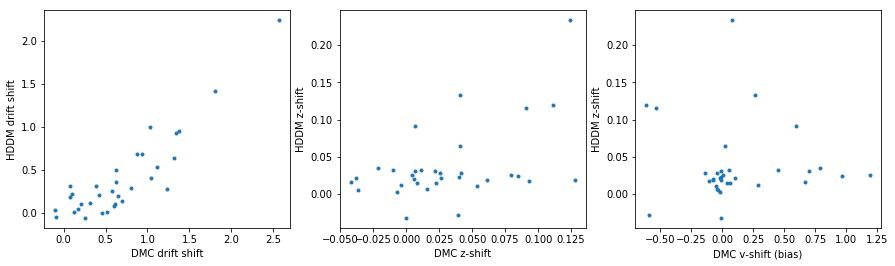

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd 
all_parameters = pd.read_pickle('./derivatives/all_subjectwise_parameters.pkl')
all_parameters = all_parameters[['ddm z_cue_regressor', 'ddm difficulty_effect']]

all_parameters_dmc = pd.read_csv('./derivatives/BMAParameters.csv')

f, ax = plt.subplots(1,3)
ax[0].plot(all_parameters_dmc['vshift'], all_parameters['ddm difficulty_effect'], '.')
ax[0].set_xlabel('DMC drift shift')
ax[0].set_ylabel('HDDM drift shift')

ax[1].plot(all_parameters_dmc['zshiftBias'], all_parameters['ddm z_cue_regressor'], '.')
ax[1].set_xlabel('DMC z-shift')
ax[1].set_ylabel('HDDM z-shift')

ax[2].plot(all_parameters_dmc['vshiftBias'], all_parameters['ddm z_cue_regressor'], '.')
ax[2].set_xlabel('DMC v-shift (bias)')
ax[2].set_ylabel('HDDM z-shift')
f.set_size_inches(15,4)

# so HDDM and DMC agree on the drift rate shift due to the difficulty effect, 
# but not on the start point shift due to the cue

In [120]:
# Let's try the DMC parameters, which are hopefully a bit better
# The third-level GLM has four EVs (and an intercept)

design_matrix = pd.DataFrame([1] * all_parameters.shape[0], columns=['intercept'])
design_matrix['dataset'] = [-1] * 19 + [1] * 14
design_matrix['z_shift'] = all_parameters_dmc['zshiftBias'].values
design_matrix['v_shift'] = all_parameters_dmc['vshift'].values
design_matrix['v_shift_bias'] = all_parameters_dmc['vshiftBias'].values
design_matrix['z_shift'] -= design_matrix['z_shift'].mean()            # demean
design_matrix['v_shift'] -= design_matrix['v_shift'].mean()            # demean
design_matrix['v_shift_bias'] -= design_matrix['v_shift_bias'].mean()  # demean

print(design_matrix.to_string(index=False))

 intercept  dataset   z_shift   v_shift  v_shift_bias
         1       -1 -0.005281 -0.176976     -0.260282
         1       -1 -0.022829 -0.481621     -0.054695
         1       -1  0.022811 -0.376061     -0.166104
         1       -1 -0.026454 -0.782216      1.074102
         1       -1 -0.008807 -0.109477     -0.081918
         1       -1 -0.052664 -0.066521      0.666750
         1       -1 -0.037841 -0.273999     -0.137538
         1       -1 -0.041110 -0.608719      0.334208
         1       -1  0.029915 -0.308145     -0.193475
         1       -1  0.009210 -0.087728     -0.125008
         1       -1 -0.069042 -0.788698     -0.135595
         1       -1 -0.004432  0.119267     -0.012215
         1       -1 -0.025390 -0.569053     -0.194321
         1       -1  0.048369  0.010570     -0.116018
         1       -1 -0.067449  0.683238     -0.149298
         1       -1  0.053906 -0.609794      0.849502
         1       -1 -0.073102 -0.431130      0.546773
         1       -1  0.09651

In [121]:
design_matrix.corr()

,intercept,dataset,z_shift,v_shift,v_shift_bias
intercept,NaN,NaN,NaN,NaN,NaN
dataset,NaN,1.000000,0.251186,0.611566,-0.352918
z_shift,NaN,0.251186,1.000000,0.271566,-0.344126
v_shift,NaN,0.611566,0.271566,1.000000,-0.510442
v_shift_bias,NaN,-0.352918,-0.344126,-0.510442,1.000000


In [123]:
def fix_fsf_file_flame1(cope,
                        orig_fsf='./derivatives/both/glm_level3/third_level_design_dmc.fsf', 
                        write_out=True):
    # read fsf as txt
    with open(orig_fsf, 'r') as f:
        fsf = f.read()
    
    # output directory
    fsf = fsf.replace("/home/stevenm/bias/derivatives/both/glm_level3/cope1",
                      "/home/stevenm/bias/derivatives/both/glm_level3/cope{}".format(cope))
    
    for ds in [1,2]:
        for sub in np.arange(1,20):
            fsf = fsf.replace('/home/stevenm/bias/derivatives/ds-0{}/feat_files/sub-{}/secondlevel.gfeat/cope1.feat'.format(ds, str(sub).zfill(2)),
                              '/home/stevenm/bias/derivatives/ds-0{}/feat_files/sub-{}/secondlevel.gfeat/cope{}.feat'.format(ds, str(sub).zfill(2), cope))
        
    # save fsf as txt
    if write_out:
        output_dir = '/home/stevenm/bias/derivatives/both/glm_level3/fsfs/cope{}'.format(cope)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        with open(os.path.join(output_dir, 'design.fsf'), 'w') as f:
            f.write(fsf)
    else:
        return fsf
    
copes = np.arange(1, 16)

for cope in copes:
    fix_fsf_file_flame1(cope=cope, write_out=True)

In [ ]:
def run_feat(fsf_file):
    print(fsf_file)
    import subprocess
    return_code = subprocess.run(["feat", fsf_file])
    print('{}: {}'.format(fsf_file, return_code))
    return return_code

# find all newly created design files
all_fsfs = sorted(glob.glob('./derivatives/both/glm_level3/fsfs/cope*/design.fsf'))
all_fsfs

with mp.Pool(30) as p:
    outputs = p.map(run_feat, all_fsfs)

./derivatives/both/glm_level3/fsfs/cope10/design.fsf
./derivatives/both/glm_level3/fsfs/cope12/design.fsf
./derivatives/both/glm_level3/fsfs/cope14/design.fsf
./derivatives/both/glm_level3/fsfs/cope13/design.fsf
./derivatives/both/glm_level3/fsfs/cope4/design.fsf
./derivatives/both/glm_level3/fsfs/cope11/design.fsf
./derivatives/both/glm_level3/fsfs/cope5/design.fsf
./derivatives/both/glm_level3/fsfs/cope2/design.fsf
./derivatives/both/glm_level3/fsfs/cope8/design.fsf
./derivatives/both/glm_level3/fsfs/cope6/design.fsf
./derivatives/both/glm_level3/fsfs/cope15/design.fsf
./derivatives/both/glm_level3/fsfs/cope1/design.fsf
./derivatives/both/glm_level3/fsfs/cope3/design.fsf
./derivatives/both/glm_level3/fsfs/cope7/design.fsf
./derivatives/both/glm_level3/fsfs/cope9/design.fsf


In [30]:
import nistats
import nibabel as nib
import nilearn
from nistats.first_level_model import FirstLevelModel
from nistats.second_level_model import SecondLevelModel
from nilearn.plotting import plot_stat_map
import os
import os.path as op
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl

%matplotlib inline

In [31]:
# load events, confounds, timeseries df
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')

events['onset'] -= 1.5  # STC

# include the following event types in the model
event_types = ['cue_left', 'easy', 'response_left', 'hard', 'error',
               'cue_neutral', 'cue_right', 'response_right']
events = events.loc[events.event_type.isin(event_types)]
events['duration'] = 0.001 # model as stick function

events = events.rename(columns={'event_type': 'trial_type'})

In [32]:
def get_sub_n(sub, max_sub_ds1=19):
    if sub > max_sub_ds1:
        sub -= max_sub_ds1
        ds = 2
    else:
        ds = 1
    return ds, sub

def get_niis(sub, run, max_sub_ds1=19):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(**locals())
    return fn

def get_brain_mask(sub, run):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(**locals())
    return fn

In [ ]:
subjects = np.arange(1, 35)
models = []

for subject in subjects:
    print('subject {}'.format(subject))
    if subject == 23:
        continue
        
    ds, ds_sub = get_sub_n(subject)
    model_fn = op.join('derivatives', 'ds-'+str(ds).zfill(2), 'glm', 'first_level_models', f'sub-{ds_sub}_glm.pkl')
    if False: #os.path.exists(model_fn):
        with open(model_fn, 'rb') as f:
            model = pkl.load(f)
    else:
        if subject == 6 or subject == 26:
            runs = [1,2]
        else:
            runs = [1,2,3]

        include = [u'dvars', u'framewise_displacement', u'a_comp_cor_00', u'a_comp_cor_01', u'a_comp_cor_02', u'a_comp_cor_03', u'a_comp_cor_04', #u'a_comp_cor_05', 
                   #u'cosine00', u'cosine01', u'cosine02', u'cosine03', u'cosine04', u'cosine05', u'cosine06',u'cosine07', u'cosine08', u'cosine09', u'cosine10', u'cosine11', u'cosine12', u'cosine13', u'cosine14', u'cosine15', 
                   # let nistats handle cosines
                   u'trans_x', u'trans_y', u'trans_z', u'rot_x', u'rot_y', u'rot_z']

        behavior = [events.loc[subject, run].reset_index(drop=True) for run in runs]
        confounds_ = [confounds.loc[subject, run].reset_index(drop=True)[include] for run in runs]
        bold_niis = [nib.load(get_niis(subject, run)) for run in runs]
        brain_mask = nib.load(get_brain_mask(subject, 1))

        model = FirstLevelModel(t_r=3,
                                mask=brain_mask,
                                drift_model='cosine',
                                smoothing_fwhm=5.0,
                                hrf_model='glover + derivative',
                                n_jobs=15,
                                subject_label=subject)

        model.fit(bold_niis,
                  behavior,
                  confounds_)
        
        with open(op.join('derivatives', 'ds-'+str(ds).zfill(2), 'glm', 'first_level_models', f'sub-{ds_sub}_glm.pkl'), 'wb') as f:
            pkl.dump(model, f, protocol=4)

    print(model.design_matrices_[0].columns)

    difficulty = model.compute_contrast('hard - easy', output_type='z_score')
    left_right_cue = model.compute_contrast('cue_left - cue_right', output_type='z_score')
    left_right_response = model.compute_contrast('response_left - response_right', output_type='z_score')
    error = model.compute_contrast('error', output_type='z_score')
    cue = model.compute_contrast('cue_left + cue_right - 2 * cue_neutral', output_type='z_score')
    
    template = op.join('derivatives', 'ds-'+str(ds).zfill(2), 'glm', 'individual_zmaps', 'sub-{subject}_desc-{contrast}_contrast.nii.gz')

    difficulty.to_filename(template.format(subject=ds_sub, contrast='difficulty'))
    left_right_cue.to_filename(template.format(subject=ds_sub, contrast='left_right_cue'))
    left_right_response.to_filename(template.format(subject=ds_sub, contrast='left_right_response'))
    error.to_filename(template.format(subject=ds_sub, contrast='error'))
    cue.to_filename(template.format(subject=ds_sub, contrast='cue'))
    
    
    models.append(model)

subject 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 

Index(['cue_left', 'cue_left_derivative', 'cue_neutral',
       'cue_neutral_derivative', 'cue_right', 'cue_right_derivative', 'easy',
       'easy_derivative', 'error', 'error_derivative', 'hard',
       'hard_derivative', 'response_left', 'response_left_derivative',
       'response_right', 'response_right_derivative', 'dvars',
       'framewise_displacement', 'a_comp_cor_00', 'a_comp_cor_01',
       'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'trans_x', 'trans_y',
       'trans_z', 'rot_x', 'rot_y', 'rot_z', 'drift_1', 'drift_2', 'drift_3',
       'drift_4', 'drift_5', 'drift_6', 'drift_7', 'drift_8', 'drift_9',
       'drift_10', 'drift_11', 'drift_12', 'drift_13', 'drift_14', 'drift_15',
       'drift_16', 'drift_17', 'drift_18', 'drift_19', 'drift_20', 'drift_21',
       'drift_22', 'drift_23', 'constant'],
      dtype='object')


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:587: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


subject 2


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The parameter "mask" will be removed in next release of Nistats. Please use the parameter "mask_img" instead.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarnin

In [42]:
def get_confounds(sub, run, confounds):
    return confounds.loc[sub, run]

def get_events(sub, run, events, onset_shift=0):
    events_ = events.loc[sub, run]
    events_['onset'] += onset_shift
    return events_

def get_sub_n(sub, max_sub_ds1=19):
    if sub > max_sub_ds1:
        sub -= max_sub_ds1
        ds = 2
    else:
        ds = 1
    return ds, sub

def get_niis(sub, run, max_sub_ds1=19):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'.format(**locals())
    return fn

def get_brain_mask(sub, run):
    ds, sub = get_sub_n(sub)
    sub_str = str(sub).zfill(2)
    run_str = str(run).zfill(2)
    ds_str = str(ds).zfill(2)
    fn = './derivatives/ds-{ds_str}/fmriprep/sub-{sub_str}/func/sub-{sub_str}_task-randomdotmotion_run-{run_str}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(**locals())
    return fn

## test run for single subject
with smoothing

In [11]:
sub = 1

onset_shift = 0 # should be best

events_ = [get_events(sub, run, events=events, onset_shift=onset_shift).reset_index(drop=True) for run in [1,2,3]]
confounds_ = [confounds_deconv.loc[sub,run].reset_index(drop=True) for run in [1,2,3]]
bold_niis = [nib.load(get_niis(sub, run)) for run in [1,2,3]]
brain_mask = nib.load(get_brain_mask(sub, 1))

fmri_glm = FirstLevelModel(t_r=3., 
                           smoothing_fwhm=5,
                           slice_time_ref=0.5,
                           mask=brain_mask,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='glover + derivative',
                           drift_model='Cosine',
                           n_jobs=-5)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
fmri_glm.fit(bold_niis, events_, confounds_)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been depr

FirstLevelModel(drift_model='Cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask=<nibabel.nifti1.Nifti1Image object at 0x7fca9a926a58>,
        memory=Memory(location=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=-5, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.5, smoothing_fwhm=5,
        standardize=False, subject_label=None, t_r=3.0, target_affine=None,
        target_shape=None, verbose=0)

In [13]:
z = fmri_glm.compute_contrast('response_left - response_right')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


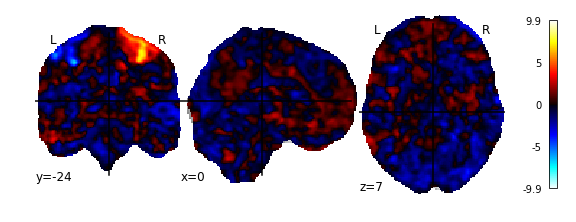

In [14]:
plot_stat_map(z)

That looks good.

## loop first-levels

Don't smooth here - smooth before 2nd-level

In [44]:
for onset_shift in [0, -1.5, 1.5, -3]:
    for sub in np.arange(1, 35):
        print(sub)
        pkl_name = 'sub-{}_shift-{}_glm.pkl'.format(sub, onset_shift)
        if os.path.exists(os.path.join('models_sm_stc', pkl_name)):
            continue
        
        if sub == 23:   # doesn't exist?
            continue
        
        runs = list(events.loc[sub].index.unique())        
        events_ = [get_events(sub, run, events=events, onset_shift=onset_shift).reset_index(drop=True) for run in runs]
        confounds_ = [confounds_deconv.loc[sub,run].reset_index(drop=True) for run in runs]
        bold_niis = [nib.load(get_niis(sub, run)) for run in runs]
        brain_mask = nib.load(get_brain_mask(sub, 1))

        fmri_glm = FirstLevelModel(t_r=3., 
                                   smoothing_fwhm=None,
                                   slice_time_ref=0.5,
                                   mask=brain_mask,
                                   noise_model='ar1',
                                   standardize=False,
                                   hrf_model='glover + derivative',
                                   drift_model='Cosine',
                                   n_jobs=-5)
        fmri_glm.fit(bold_niis, events_, confounds_)
        
        with open(os.path.join('models_sm_stc', pkl_name), 'wb') as f:
            pkl.dump(fmri_glm, f, protocol=4)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
